In [28]:
import pandas as pd
import openai
from sklearn.preprocessing import LabelEncoder                                              

In [118]:
grammer_data = pd.read_csv("./grammer_data.csv", header=1)

In [119]:
grammer_data.head()

,category,detail,difficulty,sentence,translate
0,문장 형식 (sentence_format),주어+완전자동사 (S+V),하,You win.,네가 이겼어.
1,문장 형식 (sentence_format),주어+완전자동사 (S+V),하,Going up?,올라가나요?
2,문장 형식 (sentence_format),주어+완전자동사 (S+V),하,Let's see.,어디 보자.
3,문장 형식 (sentence_format),주어+완전자동사 (S+V),하,Let's try.,한 번 해봅시다.
4,문장 형식 (sentence_format),주어+완전자동사 (S+V),하,Speak out.,거리낌 없이 얘기 해.


In [175]:
from collections import defaultdict

class MultiColLabelEncoder:
    def __init__(self) -> None:
        self.encoder_dict = defaultdict(LabelEncoder)

    def fit_transform(self, X: pd.DataFrame, columns: str):
        # if not isinstance(columns, list):
        #     columns = [columns]

        output = X.copy()
        output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].fit_transform(x))
        return output
    
    def inverse_transform(self, X: pd.DataFrame, columns: str):
        # if not isinstance(columns, list):
        #     columns[columns]
        if not all(key in self.encoder_dict for key in columns):
            raise KeyError(f'At least one of {columns} is not encoded before')

        output = X.copy()
        try:
            output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].inverse_transform(x))
        except ValueError:
            print(f'Need assingment when do "fit_transform" function')
            raise
        return output

In [199]:
import pickle
import re

dataset={}

for category in grammer_data['category'].unique():
    english_pattern = re.compile(r'\b[a-zA-Z_]+\b')
    en_key= category if english_pattern.findall(category)==[] else english_pattern.findall(category)[0]
    dataset[en_key] = grammer_data[grammer_data['category']==category][['category','detail','sentence']]
    encoder = LabelEncoder()
    dataset[en_key]['detail']=encoder.fit_transform(dataset[en_key]['detail'].values)
    with open(f'key_dict/key_dict_{en_key}.pkl', 'wb') as f:
        pickle.dump(encoder.classes_, f)

In [194]:
dataset.keys()

dict_keys(['sentence_format', 'sentence_type', 'sentence_component', 'nouns', 'referents', 'verbs', 'tense', 'modals', 'adjectives', 'adverbs', 'prepositions', 'conjunctions', 'determiners', 'negation', 'exceptions', 'participle', 'gerunds', 'infinitives', 'comparison', 'relatives', 'voice', 'subjunctives', 'transformation', 'frequent_syntax', 'Idioms', 'communicatives'])

In [198]:
import pandas as pd
import json
import glob, os

# dataset_folder_path='./dataset/'
# if os.path.exists(dataset_folder_path):
#     os.system(f"rm -r {dataset_folder_path}")
    
# Create the new folder
if not os.path.exists('./dataset/'):
    os.makedirs('./dataset/')
df_dict={}
for idx, key in enumerate(dataset.keys()):
    labels = [i for i in dataset[key]['detail']]
    texts = [i for i in dataset[key]['sentence']]
    df_dict[key] = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
    df_json = df_dict[key].to_json(f"dataset/{key}.jsonl", orient='records', lines=True)

sentence_format
sentence_type
sentence_component
nouns
referents
verbs
tense
modals
adjectives
adverbs
prepositions
conjunctions
determiners
negation
exceptions
participle
gerunds
infinitives
comparison
relatives
voice
subjunctives
transformation
frequent_syntax
Idioms
communicatives


In [8]:
!pip install --upgrade openai

In [200]:
filename='adjectives'

In [201]:
!openai tools fine_tunes.prepare_data -f dataset/{filename}.jsonl -q
!mv dataset/{filename}_prepared_train.jsonl train_valid_dataset/{filename}_prepared_train.jsonl
!mv dataset/{filename}_prepared_valid.jsonl train_valid_dataset/{filename}_prepared_valid.jsonl

Analyzing...

- Your file contains 708 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more det

In [202]:
import jsonlines

l=[]
with jsonlines.open(f"train_valid_dataset/{filename}_prepared_train.jsonl") as f:
    for line in f.iter():
    	l.append(line)

In [203]:
df=pd.DataFrame(l)
n=df['completion'].nunique()

In [ ]:
if not os.path.exists('./train_valid_dataset'):
    os.makedirs('./train_valid_dataset')
    print("make train_valid_dataset folder done")

In [204]:
!openai api fine_tunes.create -t "train_valid_dataset/{filename}_prepared_train.jsonl" -v "train_valid_dataset/{filename}_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes {n}  -m ada

Upload progress: 100%|████████████████████| 45.3k/45.3k [00:00<00:00, 30.4Mit/s]
Uploaded file from train_valid_dataset/adjectives_prepared_train.jsonl: file-LVbEWVGghQaLcozba5lCsOyA
Upload progress: 100%|████████████████████| 12.0k/12.0k [00:00<00:00, 12.8Mit/s]
Uploaded file from train_valid_dataset/adjectives_prepared_valid.jsonl: file-11pWdI0IEAJbKvObCv8QclQa
Created fine-tune: ft-w460tbtixUivVXwqLCjMhrgf
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-02-15 13:58:42] Created fine-tune: ft-w460tbtixUivVXwqLCjMhrgf


In [ ]:
!openai api fine_tunes.follow -i ft-AyPgveTDlwkTnWEIYV1HFAGm

[2023-02-15 00:47:08] Created fine-tune: ft-AyPgveTDlwkTnWEIYV1HFAGm
^C


In [23]:
if not os.path.exists('./result'):
    os.makedirs('./result')
    print("make result folder done")

In [179]:
!openai api fine_tunes.results -i ft-uXAk6ISjTGbgMTbhzKWUDtsq > result/result_{filename}.csv

In [183]:
results = pd.read_csv(f'result/result_{filename}.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
2375,2376,77776,4752,0.014388,1.0,1.0,NaN,NaN,NaN,0.89899,0.892924


<AxesSubplot:>

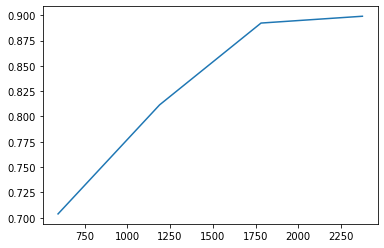

In [184]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

In [115]:
test = pd.read_json(f'train_valid_dataset/{filename}_prepared_valid.jsonl', lines=True)
test[test['completion']==19]

,prompt,completion
256,"Avoid the evil, and it will avoid thee. ->",19
257,"Do your best, and you will not regret it. ->",19
258,Give someone an inch and they will take a mile...,19
259,"Face your fears and doubts, and new worlds wil...",19
260,Tell me and I forget. Teach me and I remember....,19
261,"Choose a job you love, and you will never have...",19
262,Love life and life will love you back. Love pe...,19
263,Let me be immune to rejection and heartbreak a...,19


In [157]:
with open(f'key_dict/key_dict_{filename}.pkl', 'rb') as f:
    key_dict = pickle.load(f)

In [174]:
ft_model = 'ada:ft-personal-2023-02-14-17-33-56'
res = openai.Completion.create(model=ft_model, prompt='save the key-value encoding dictionary ->', max_tokens=1, temperature=0)
key_dict[int(res['choices'][0]['text'][1:])]

'간접의문문 어순 변화'

In [165]:
filename

'sentence_type'